# Setup

In [1]:
!conda env list

# conda environments:
#
base                     /home/esheder/miniconda3
isos                     /home/esheder/miniconda3/envs/isos
noise                 *  /home/esheder/miniconda3/envs/noise
snakes                   /home/esheder/miniconda3/envs/snakes



In [2]:
import pandas as pd
import numpy as np
from sde_signals import par
from scipy.stats import norm, shapiro
import matplotlib.pyplot as plt

# SDE Correctness

## SDE Signal Example

In [151]:
from sde_signals import feynman_y_by_signal, Parameters
from noise.analytic import feynman_y_model, fit_to_feynman_y

In [152]:
multiplicity = np.array([0.13, 0.22, 0.2, 0.2, 0.1, 0.1, 0.05])
nu = (multiplicity * np.arange(len(multiplicity))).sum()
moment2 = (multiplicity * (np.arange(len(multiplicity)) ** 2)).sum()
lifetimes = np.logspace(-6, -4, num=10)
sources = np.logspace(3, 7, num=10)
detections = np.logspace(-6, -2, num=10)
defaults = {'Λ': lifetimes[-2], 's': sources[5], 'pd': detections[5]}
par = Parameters.from_dubi(ν=nu, ν2=moment2, ρ=-1e3*1e-5, **defaults)
print(defaults)

{'Λ': 5.994842503189409e-05, 's': 166810.0537200059, 'pd': 0.0001668100537200059}


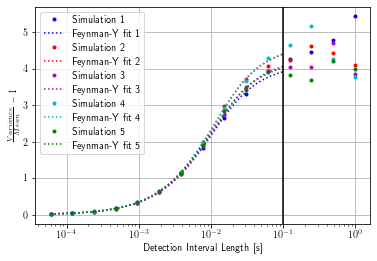

In [153]:
plt.rcParams['text.usetex'] = True
colors = ['b', 'r', 'm', 'c', 'g']
for seed, color in enumerate(colors, start=1):
    rgen = np.random.Generator(np.random.SFC64(seed))
    winsize, fy, sigma = feynman_y_by_signal(par, 60, rand_gen=rgen)
    mask = (winsize <= 1e-1)
    tfit, cfit, sfit = winsize[mask], fy[mask], sigma[mask]
    popt, pcov = fit_to_feynman_y(tfit, cfit, sfit)
    xfine = np.logspace(np.log10(winsize[0]), np.log10(1e-1), 500)
    yfine = feynman_y_model(xfine, *popt)
    plt.semilogx(winsize, fy, f'.{color}', label=f'Simulation {seed}')
    plt.semilogx(xfine, yfine, f'{color}:', label=f'Feynman-Y fit {seed}')
plt.grid()
plt.xlabel('Detection Interval Length [s]')
plt.ylabel(r'$\frac{Variance}{Mean}-1$')
plt.axvline(0.1, color='k')
plt.legend()
plt.savefig('Example_SDE_model_generated_signal.jpg', dpi=600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


15 15


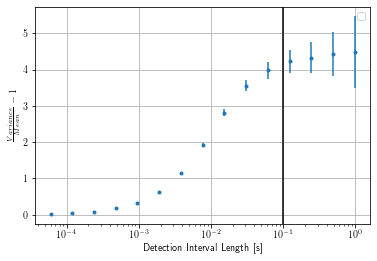

In [159]:
plt.rcParams['text.usetex'] = True
colors = ['b', 'r', 'm', 'c', 'g']
winsize, fy, sigma = feynman_y_by_signal(par, 60)
res = np.empty((100, len(winsize)), float)
for seed in range(100):
    rgen = np.random.Generator(np.random.SFC64(seed))
    winsize, fy, sigma = feynman_y_by_signal(par, 60, rand_gen=rgen)
    res[seed,:] = fy
y = res.mean(axis=0)
dy = res.std(axis=0)
plt.errorbar(winsize, y, yerr=dy, fmt='.')
plt.xscale('log')
plt.grid()
plt.xlabel('Detection Interval Length [s]')
plt.ylabel(r'$\frac{Variance}{Mean}-1$')
plt.axvline(0.1, color='k')
plt.legend()
plt.savefig('SDE_model_signal_variance.jpg', dpi=600)

## Correctness by Statistics

In [3]:
sdedf = pd.read_csv('sde_data/theta_data.csv').set_index(['Seed'])
sdedf

,Theta,Inf,Alpha
Seed,,,
2001,0.0,10.4822,99.6003
2001,0.5,10.4827,99.0996
2001,1.0,10.4831,98.6039
2002,0.0,10.5837,99.2751
2002,0.5,10.5842,98.7750
...,...,...,...
7999,0.5,10.3855,100.2340
7999,1.0,10.3854,99.7314
8000,0.0,10.2859,100.6530


In [4]:
par.α

-100.0

In [5]:
mean, std = norm.fit(sdedf[sdedf.Theta==0.]['Alpha'])
mean, std

(100.62479979999999, 1.5339972922466194)

In [6]:
assert np.isclose(mean, -par.α, atol=std, rtol=1e-20)

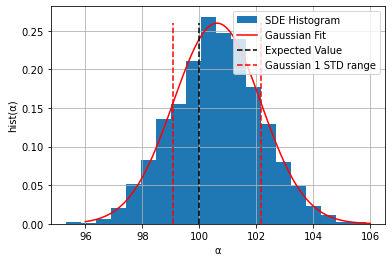

In [7]:
forward = sdedf[sdedf.Theta==0.]
forward['Alpha'].hist(bins=20, density=True, label='SDE Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(forward['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.savefig('SDE_Histogram.jpg', dpi=600)
plt.savefig('SDE_Histogram.svg', dpi=600)

In [8]:
sdemean, sdestd = norm.fit(forward.Alpha)
testval = norm(100, sdestd/np.sqrt(len(forward.Alpha.values)-1))
2*(1. - testval.cdf(sdemean)), forward.Alpha.std()/np.sqrt(len(forward.Alpha.values)), forward.Alpha.mean()

(0.0, 0.03430980075027749, 100.62479979999999)

Soemthing is a little off. We would expect α to be replicated around its expected value, and this feels wrong.
We should use a statistical test to verify if this shift could be explained, but I highly doubt that. I feel like there is a very small and stupid bug in my code.

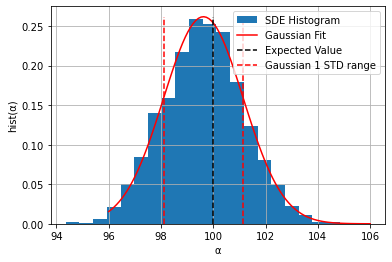

In [9]:
backward = sdedf[sdedf.Theta==1.]
backward['Alpha'].hist(bins=20, density=True, label='SDE Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(backward['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.savefig('SDE_Histogram_backward.jpg', dpi=600)
plt.savefig('SDE_Histogram_backward.svg', dpi=600)

In [10]:
sdemean, sdestd = norm.fit(backward.Alpha)
testval = norm(100, sdestd/np.sqrt(len(backward.Alpha.values)-1))
2*testval.cdf(sdemean), backward.Alpha.std()/np.sqrt(len(backward.Alpha.values)), backward.Alpha.mean()

(1.859321164840012e-28, 0.03406936000236068, 99.62303025)

This is still a little bit off, but less so. Therefore the numerical method does matter and it does change the result. That's important to note.

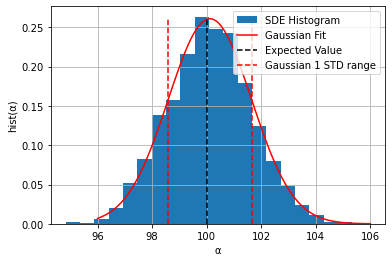

In [11]:
crank = sdedf[sdedf.Theta==0.5]
crank['Alpha'].hist(bins=20, density=True, label='SDE Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(crank['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.savefig('SDE_Histogram_crank.jpg', dpi=600)
plt.savefig('SDE_Histogram_crank.svg', dpi=600)

The Crank-Nickolson seems right on the money. OK. I think we got this.

In [12]:
shapiro(crank.Alpha)

ShapiroResult(statistic=0.9993764758110046, pvalue=0.7786957621574402)

As expected this is kind of a normal distribution.

In [13]:
sdemean, sdestd = norm.fit(crank['Alpha'])
testval = norm(100, sdestd/np.sqrt(len(crank.Alpha.values)-1))
2*(1. - testval.cdf(sdemean)), crank.Alpha.std()/np.sqrt(len(crank.Alpha.values)), crank.Alpha.mean()

(0.0003834239500566383, 0.034188953249717234, 100.12141310000001)

# Analog

In [14]:
analogdf = pd.read_csv('analog_data.csv').set_index('Seed')
analogdf

,Inf,Alpha
Seed,,
1,10.3139,100.6600
10,10.6894,98.1019
100,10.5791,100.3220
1000,10.4034,100.2430
101,10.4815,100.0810
...,...,...
995,10.4780,98.0817
996,10.4712,99.5976
997,10.5194,100.5660


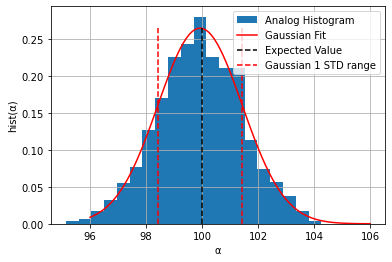

In [15]:
analogdf['Alpha'].hist(bins=20, density=True, label='Analog Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

analogmean, analogstd = norm.fit(analogdf['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=analogmean, scale=analogstd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([analogmean-analogstd, analogmean-analogstd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([analogmean+analogstd, analogmean+analogstd], [0, mx], '--r')
plt.legend()
plt.savefig('Analog_Histogram.jpg', dpi=600)
plt.savefig('Analog_Histogram.svg', dpi=600)

Now this is how we expected the model to behave!

In [16]:
mean, std = norm.fit(analogdf['Alpha'])
mean, std, shapiro(analogdf.Alpha)

(99.92867,
 1.504638732354049,
 ShapiroResult(statistic=0.9988510608673096, pvalue=0.7874799966812134))

In [17]:
testval = norm(100., analogdf.Alpha.std()/np.sqrt(len(analogdf.Alpha.values)))
testval.cdf(analogdf.Alpha.mean()), analogdf.Alpha.std()/np.sqrt(len(analogdf.Alpha.values)), analogdf.Alpha.mean() - 100

(0.06701693287687802, 0.047604662784424996, -0.07133000000000322)

In [18]:
assert np.isclose(mean, -par.α, atol=std, rtol=1e-20)

# Analog Timing

In [160]:
timedf = pd.read_csv('analog_timing_data.csv')
timedf

,Reactivity,Lifetime,Source,Detection Rate,Measurement Time,Seed,Runtime,Inf,Alpha
0,-0.01,0.00006,166810.1,0.000001,60.0,0,150.45,0.821737,1.339250
1,-0.01,0.00006,166810.1,0.000001,60.0,1,147.87,0.138980,72.961800
2,-0.01,0.00006,166810.1,0.000001,60.0,10,156.83,0.023257,105.912000
3,-0.01,0.00006,166810.1,0.000001,60.0,11,152.63,0.012874,1744.450000
4,-0.01,0.00006,166810.1,0.000001,60.0,12,152.45,0.163551,-0.000951
...,...,...,...,...,...,...,...,...,...
2495,-0.01,0.00006,166810.1,0.000167,60.0,5,190.92,4.619970,155.468000
2496,-0.01,0.00006,166810.1,0.000167,60.0,6,186.33,4.300520,158.704000
2497,-0.01,0.00006,166810.1,0.000167,60.0,7,182.81,4.570540,159.492000
2498,-0.01,0.00006,166810.1,0.000167,60.0,8,191.54,4.684980,165.251000


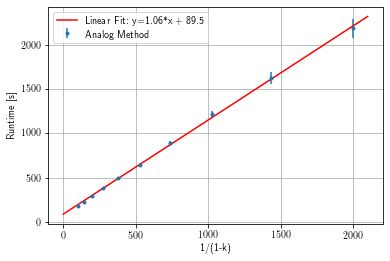

In [161]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index()
       .assign(k=lambda x: 1/(1-x.Reactivity)).assign(**{'1/(1-k)': lambda y: 1/(1-y.k)}))
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['1/(1-k)'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['1/(1-k)'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.grid()
plt.xlabel('1/(1-k)')
plt.ylabel('Runtime [s]')
fx = np.linspace(0, 2100, num=100)
fy = v[1] + v[0]*fx
plt.plot(fx, fy, 'r', label=f'Linear Fit: y={v[0]:.2f}*x + {v[1]:.1f}')
plt.legend()
plt.savefig('Analog_Reactivity_Runtime.jpg', dpi=600)

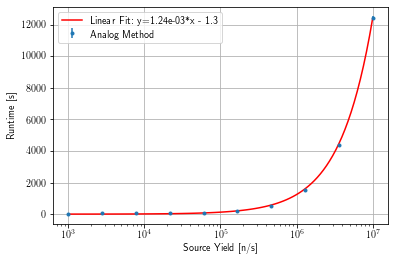

In [162]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Source'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['Source'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('Source Yield [n/s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(3, 7, num=100)
fy = v[1] + v[0]*fx
plt.plot(fx, fy, 'r', label=f'Linear Fit: y={v[0]:.2e}*x - {-v[1]:.1f}')
plt.legend()
plt.savefig('Analog_Source_Runtime.jpg', dpi=600)

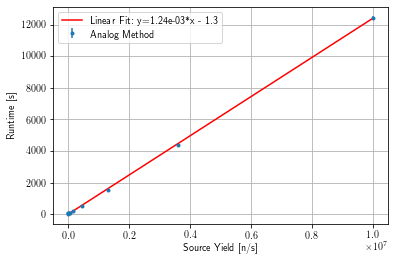

In [163]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Source'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['Source'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
#plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('Source Yield [n/s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(3, 7, num=100)
fy = v[1] + v[0]*fx
plt.plot(fx, fy, 'r', label=f'Linear Fit: y={v[0]:.2e}*x - {-v[1]:.1f}')
plt.legend()
plt.savefig('Analog_Source_Runtime_linear.jpg', dpi=600)

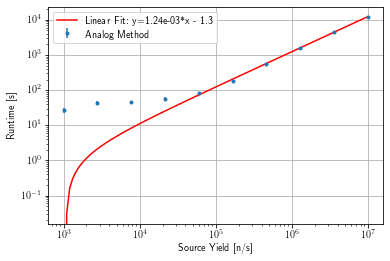

In [166]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Source'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['Source'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.xlabel('Source Yield [n/s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(3, 7, num=100)
fy = v[1] + v[0]*fx
plt.plot(fx, fy, 'r', label=f'Linear Fit: y={v[0]:.2e}*x - {-v[1]:.1f}')
plt.legend()
plt.savefig('Analog_Source_Runtime_loglog.jpg', dpi=600)

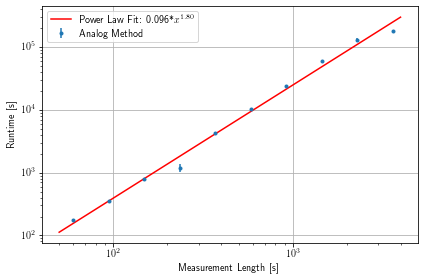

In [172]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=np.log(dat['Measurement Time'].values), y=np.log(dat['Runtime'].values), deg=1)
plt.errorbar(dat['Measurement Time'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.xlabel('Measurement Length [s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(1.7, 3.6, num=100)
fy = np.exp(v[1])*(fx**v[0])
plt.plot(fx, fy, 'r', label=f'Power Law Fit: {np.exp(v[1]):.3f}*' + ('$x^{%.2f}$' % v[0]))
plt.legend()
plt.tight_layout()
plt.savefig('Analog_Measurement_Runtime.jpg')

# SDE Timing

In [76]:
sdetimedf = pd.read_csv('sde_timing_data.csv')
sdetimedf

,Reactivity,Lifetime,Source,Detection Rate,Measurement Time,Seed,Runtime,Inf,Alpha
0,-0.01,0.00006,166810.1,0.000001,60.0,0,0.76427,-0.043413,4.328070e-02
1,-0.01,0.00006,166810.1,0.000001,60.0,1,0.80481,2.457910,1.319140e+00
2,-0.01,0.00006,166810.1,0.000001,60.0,10,0.87147,0.050798,1.271340e+05
3,-0.01,0.00006,166810.1,0.000001,60.0,11,0.73257,-0.047773,9.385140e+11
4,-0.01,0.00006,166810.1,0.000001,60.0,12,0.81989,0.414449,1.242360e+00
...,...,...,...,...,...,...,...,...,...
2491,-0.01,0.00006,166810.1,0.000167,60.0,5,0.72492,4.268690,1.748520e+02
2492,-0.01,0.00006,166810.1,0.000167,60.0,6,0.71770,4.498570,1.547770e+02
2493,-0.01,0.00006,166810.1,0.000167,60.0,7,0.72296,4.536450,1.593370e+02
2494,-0.01,0.00006,166810.1,0.000167,60.0,8,0.70648,4.544860,1.666230e+02


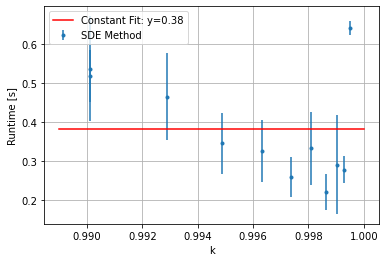

In [77]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index()
       .assign(k=lambda x: 1/(1-x.Reactivity)))
stdr = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['k'].values, y=dat['Runtime'].values, deg=0)
plt.errorbar(dat['k'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='SDE Method')
plt.grid()
plt.xlabel('k')
plt.ylabel('Runtime [s]')
fx = np.linspace(0.989, 1, num=100)
fy = v[0]*np.ones_like(fx)
plt.plot(fx, fy, 'r', label=f'Constant Fit: y={v[0]:.2f}')
plt.legend()
plt.savefig('SDE_Reactivity_Runtime.jpg', dpi=600)

In [25]:
dat.Runtime.max()

0.6410106521739131

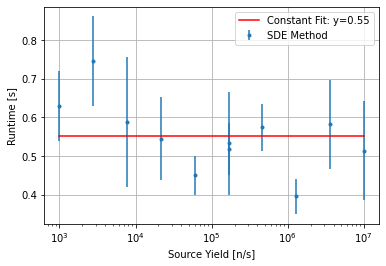

In [78]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Source'].values, y=dat['Runtime'].values, deg=0)
plt.errorbar(dat['Source'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='SDE Method')
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('Source Yield [n/s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(3, 7, num=100)
fy = v[0]*np.ones_like(fx)
plt.plot(fx, fy, 'r', label=f'Constant Fit: y={v[0]:.2f}')
plt.legend()
plt.savefig('SDE_Source_Runtime.jpg', dpi=600)

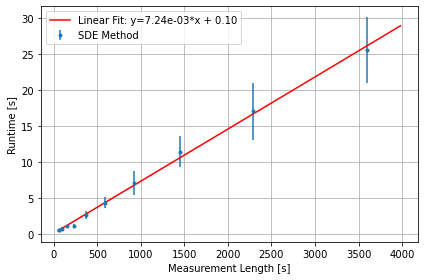

In [82]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Measurement Time'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['Measurement Time'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='SDE Method')
plt.grid()
plt.xlabel('Measurement Length [s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(1.7, 3.6, num=100)
fy = v[1]+ (fx*v[0])
plt.plot(fx, fy, 'r', label=f'Linear Fit: y={v[0]:.2e}*x + {v[1]:.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('SDE_Measurement_Runtime.jpg')

In [28]:
dat.Runtime.max()

25.571019999999997

# Speedup

In [29]:
sdemeandf = sdetimedf.groupby(rhoindex).mean().reset_index()
sdemeandf['SDE RuntimeSTD'] = sdetimedf.groupby(rhoindex).std().reset_index()['Runtime']
sdemeandf.drop(columns=['Seed'], inplace=True)
sdemeandf.rename(columns = {'Runtime': 'SDE Runtime', 'Inf': 'SDE YInf', 'Alpha': 'SDE Alpha Mean'}, inplace=True)

In [30]:
analogmeandf =  timedf.groupby(rhoindex).mean().reset_index()
analogmeandf['Analog RuntimeSTD'] = timedf.groupby(rhoindex).std().reset_index()['Runtime']
analogmeandf.drop(columns=['Seed'], inplace=True)
analogmeandf.rename(columns = {'Runtime': 'Analog Runtime', 'Inf': 'Analog Yinf', 'Alpha': 'Analog Alpha Mean'}, inplace=True)

In [31]:
combined = (pd.concat([analogmeandf.groupby(rhoindex).mean(), 
                       sdemeandf.groupby(rhoindex).mean()], 
                      axis=1)
            .reset_index()
            .assign(speedup=lambda x: x['Analog Runtime']/x['SDE Runtime'])
            .assign(dspeedup=lambda x: np.sqrt(x['Analog RuntimeSTD']**2/x['SDE Runtime']**2 
                                               + x['Analog Runtime']**2*x['SDE RuntimeSTD']**2/x['SDE Runtime']**4)))
filtered = (combined.drop(columns=set(combined.columns) - (set(rhoindex) | {'speedup', 'dspeedup'}))
            .groupby(['Source', 'Measurement Time', 'Reactivity'])
            .mean().reset_index().drop(columns=['Lifetime', 'Detection Rate']))
filtered

,Source,Measurement Time,Reactivity,speedup,dspeedup
0,1.000000e+03,60.00000,-0.010000,42.065348,8.736654
1,2.782559e+03,60.00000,-0.010000,57.888087,11.480643
2,7.742637e+03,60.00000,-0.010000,76.296521,23.437574
3,2.154435e+04,60.00000,-0.010000,105.104669,22.951424
4,5.994843e+04,60.00000,-0.010000,187.230342,24.773429
5,1.668101e+05,60.00000,-0.010000,273.912160,57.405083
6,1.668101e+05,60.00000,-0.007169,493.709343,119.768737
7,1.668101e+05,60.00000,-0.005139,847.111693,196.043305
8,1.668101e+05,60.00000,-0.003684,1184.322548,289.448263
9,1.668101e+05,60.00000,-0.002641,1904.617375,380.178024


In [32]:
filtered.speedup.min(), filtered.speedup.max()

(42.06534759721429, 24191.146614177702)

# $\alpha$ Deviation Analysis

In [33]:
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat

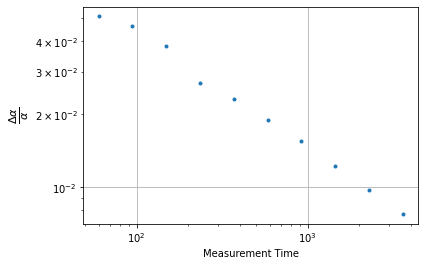

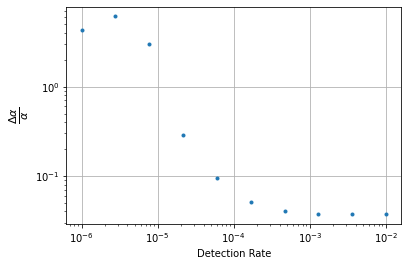

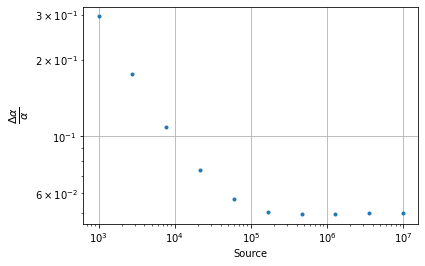

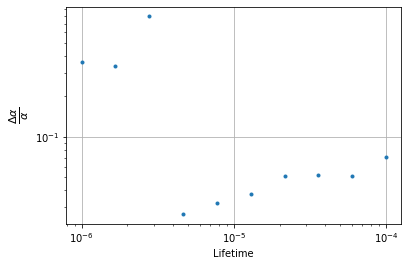

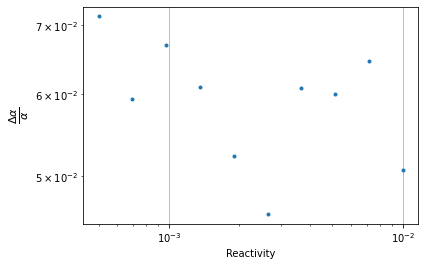

In [34]:
sdestddf = pd.read_csv('sde_timing_data.csv')
keys = ['Reactivity', 'Lifetime', 'Source', 'Detection Rate', 'Measurement Time']
grpd = sdestddf.groupby(keys)
stddata = grpd.std()['Alpha']
stddata.name = 'Alpha STD'
meandata = grpd.mean()['Alpha']
newdata = pd.concat([meandata, stddata], axis=1)
defaults = {key: newdata.reset_index()[key].mode()[0] for key in keys}
levels = {key: i for i, key in enumerate(defaults.keys())}
options = list(map(dict, it.combinations(defaults.items(), len(defaults)-1)))
slices = list(map(lambda x: tuple({key: x.get(key, slice(None)) for key in keys}.values()), options))
val_names = ['Alpha', 'Alpha STD']
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, y = dat[unkey], dat['Alpha STD'] / dat['Alpha']
    plt.figure()
    plt.loglog(abs(x), y, '.')
    plt.xlabel(unkey)
    plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=16)
    plt.grid()
    plt.show()

## Full data analysis

In [84]:
sdestddf = pd.read_csv('sde_std_fixed.csv').assign(
    AlphaCor=lambda x: [ufloat(*y) for y in zip(x.Alpha.values, np.sqrt(x.ConvAlphaAlpha))])
keys = ['Reactivity', 'Lifetime', 'Source', 'Detection Rate', 'Measurement Time']
grpd = sdestddf.groupby(keys)
stddata = grpd.Alpha.std()
stddata.name = 'Alpha STD'
meandata = grpd.AlphaCor.aggregate(lambda x: sum(x)/len(x))
meandata.name = 'Alpha'
newdata = pd.concat([meandata, stddata], axis=1)
defaults = {key: newdata.reset_index()[key].mode()[0] for key in keys}
levels = {key: i for i, key in enumerate(defaults.keys())}
options = list(map(dict, it.combinations(defaults.items(), len(defaults)-1)))
slices = list(map(lambda x: tuple({key: x.get(key, slice(None)) for key in keys}.values()), options))
val_names = ['Alpha', 'Alpha STD']

In [85]:
sdestddf

,Reactivity,Lifetime,Source,Detection Rate,Measurement Time,Seed,Inf,Alpha,CovInf,CovInfAlpha,CovAlphaInf,ConvAlphaAlpha,AlphaCor
0,-0.0005,0.00006,166810.1,0.000167,60.0,0,1580.73000,8.83991,44.434900,-0.277678,-0.277678,0.001743,8.84+/-0.04
1,-0.0005,0.00006,166810.1,0.000167,60.0,1,1762.81000,8.63753,34.871600,-0.190514,-0.190514,0.001045,8.638+/-0.032
2,-0.0005,0.00006,166810.1,0.000167,60.0,2,2900.93000,6.16167,2605.330000,-5.998850,-5.998850,0.013843,6.16+/-0.12
3,-0.0005,0.00006,166810.1,0.000167,60.0,3,1798.92000,8.20679,133.379000,-0.675258,-0.675258,0.003432,8.21+/-0.06
4,-0.0005,0.00006,166810.1,0.000167,60.0,4,1612.33000,8.79057,27.069000,-0.164827,-0.164827,0.001008,8.791+/-0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,-0.0100,0.00006,166810.1,0.000167,3600.0,946,4.37960,168.41800,0.000029,-0.001592,-0.001592,0.110524,168.42+/-0.33
50996,-0.0100,0.00006,166810.1,0.000167,3600.0,947,4.40141,167.66700,0.000024,-0.001336,-0.001336,0.091793,167.67+/-0.30
50997,-0.0100,0.00006,166810.1,0.000167,3600.0,948,4.41501,166.03700,0.000059,-0.003198,-0.003198,0.216751,166.0+/-0.5
50998,-0.0100,0.00006,166810.1,0.000167,3600.0,949,4.32760,170.21900,0.000139,-0.007872,-0.007872,0.559387,170.2+/-0.7


In [86]:
np.array([0.13, 0.22, 0.2, 0.2, 0.1, 0.1, 0.05]) @ (np.arange(0,7)**2)

8.72

In [87]:
prob_case = sdestddf.mode()
prob_case.iloc[0]

Reactivity             -0.01
Lifetime             0.00006
Source              166810.1
Detection Rate      0.000167
Measurement Time        60.0
Seed                    50.0
Inf                      1.0
Alpha                165.031
CovInf                   inf
CovInfAlpha              inf
CovAlphaInf        -0.226583
ConvAlphaAlpha       3.85702
AlphaCor             -3+/-25
Name: 0, dtype: object

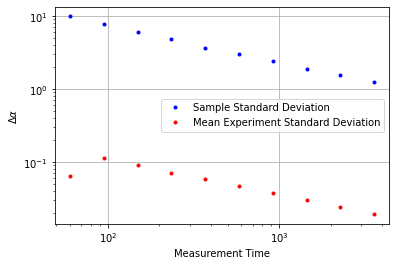

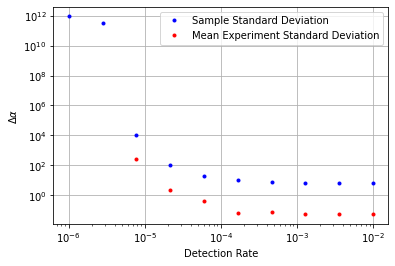

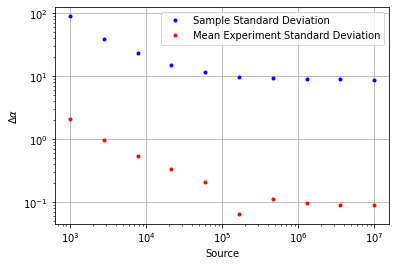

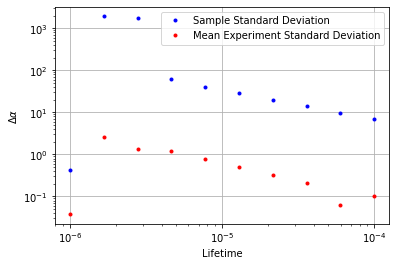

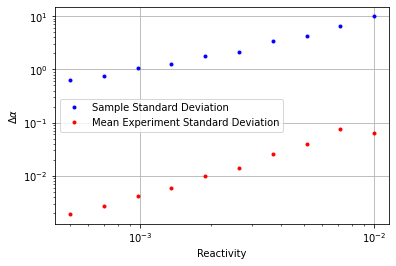

In [88]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy, erry = dat[unkey], dat['Alpha STD'], [z.s for z in dat['Alpha']]
    plt.figure()
    plt.loglog(abs(x), stdy, 'b.', label='Sample Standard Deviation')
    plt.loglog(abs(x), erry, 'r.', label='Mean Experiment Standard Deviation')
    plt.xlabel(unkey)
    plt.ylabel(r'$\Delta\alpha$')
    plt.grid()
    plt.legend()

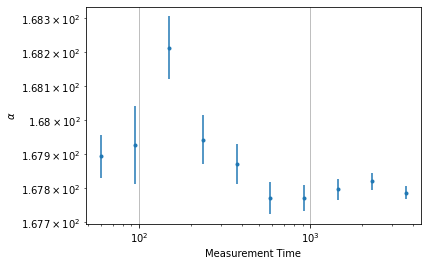

/home/esheder/miniconda3/envs/noise/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/esheder/miniconda3/envs/noise/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


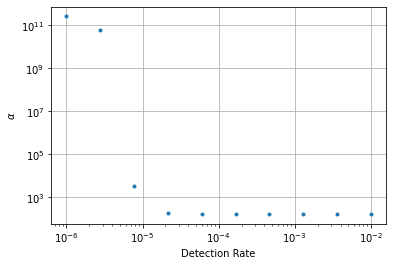

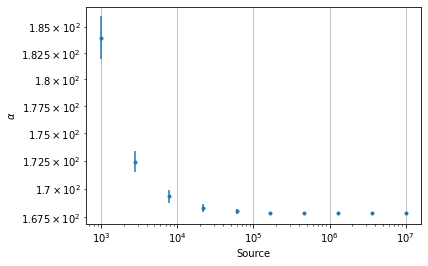

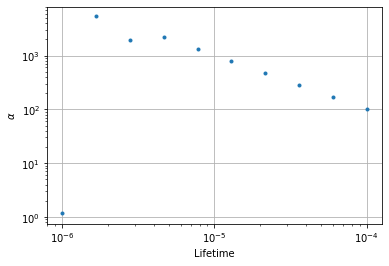

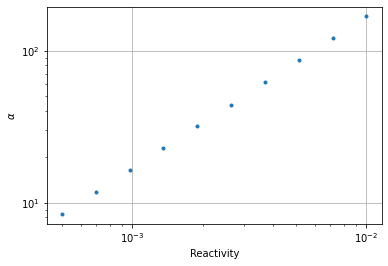

In [89]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy = dat[unkey], dat['Alpha']
    y, yerr = [z.n for z in stdy], [z.s for z in stdy]
    plt.figure()
    plt.errorbar(abs(x), y, yerr=yerr, fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(unkey)
    plt.ylabel(r'$\alpha$')
    plt.grid()
    plt.show()

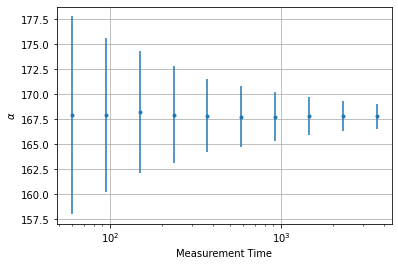

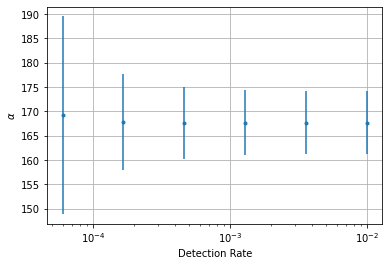

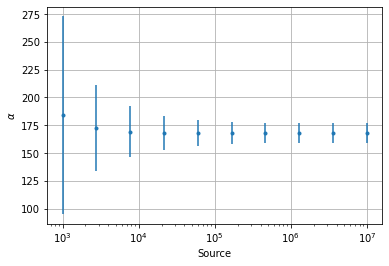

In [90]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    if unkey in {'Lifetime', 'Reactivity'}:
        continue
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy, sampledy = dat[unkey], dat['Alpha'], dat['Alpha STD']
    y, yerr = np.array([z.n for z in stdy]), [z.s for z in stdy]
    mask = sampledy.values<0.5*y
    x, y, dy = x[mask], y[mask], sampledy[mask]
    plt.figure()
    plt.errorbar(abs(x), y, yerr=dy, fmt='.')
    plt.xscale('log')
    plt.xlabel(unkey)
    plt.ylabel(r'$\alpha$')
    plt.grid()
    plt.show()

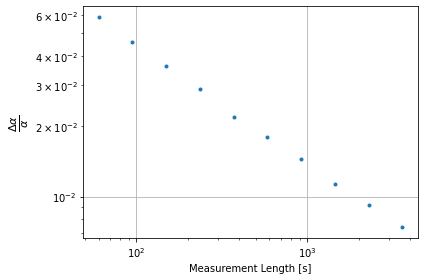

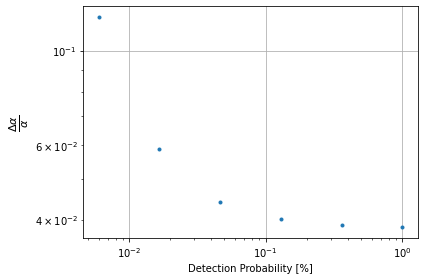

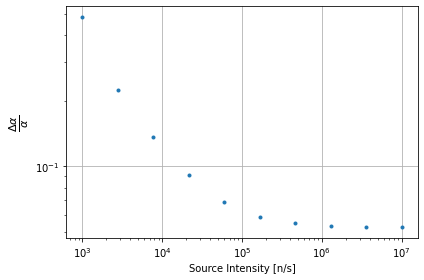

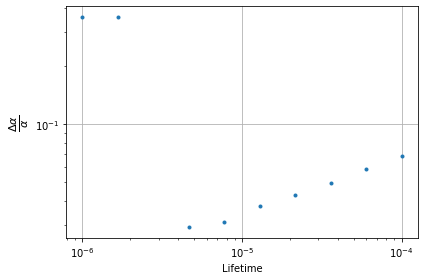

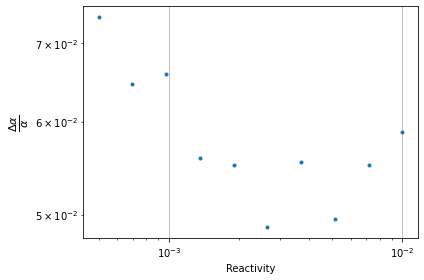

In [91]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy, sampledy = dat[unkey], dat['Alpha'], dat['Alpha STD']
    y, yerr = np.array([z.n for z in stdy]), [z.s for z in stdy]
    mask = sampledy.values<0.5*y
    x, y, dy = x[mask], y[mask], sampledy[mask]
    if 'Detection' in unkey:
        x = 100 * x
    plt.figure()
    plt.loglog(abs(x), dy/y, '.')
    plt.xlabel(unkey.replace('Rate', 'Probability [%]').replace('Source', 'Source Intensity [n/s]').replace('Measurement Time', 'Measurement Length [s]'))
    plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=16)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"sde_std_{unkey.replace(' ','_')}.jpg", dpi=600)

In [43]:
def inv_sqrt(x, a):
    return a/np.sqrt(x)

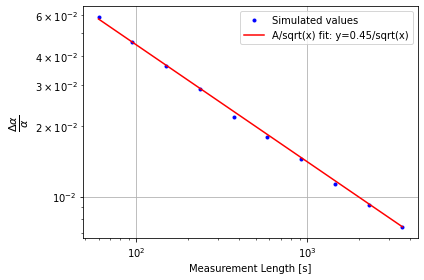

In [93]:
import scipy.optimize as scopt
option = options[0]
slc = slices[0]
unkey = (set(defaults.keys()) - set(option.keys())).pop()
dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
x, stdy, sampledy = dat[unkey], dat['Alpha'], dat['Alpha STD']
y, yerr = np.array([z.n for z in stdy]), [z.s for z in stdy]
mask = sampledy.values<0.5*y
x, y, dy = x[mask], y[mask], sampledy[mask]
popt, fitcov = scopt.curve_fit(inv_sqrt, x, dy/y, bounds=(1e-4, 1))
xfine = np.linspace(min(x), max(x), 500)
yfine = inv_sqrt(xfine, popt[0])

plt.figure()
plt.loglog(x, dy/y, 'b.', label='Simulated values')
plt.loglog(xfine, yfine, 'r-', label=f'A/sqrt(x) fit: y={popt[0]:.2f}/sqrt(x)') 
plt.xlabel('Measurement Length [s]')
plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=16)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('SDE_Measurement_Time_Relative_Error.jpg', dpi=600)

### Histogram

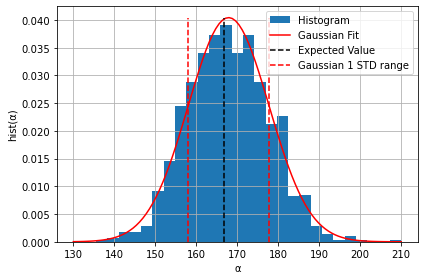

In [45]:
productdf = pd.read_csv('sde_std_fixed.csv')
groups = ['Source', 'Reactivity', 'Measurement Time', 'Lifetime', 'Detection Rate']
default = productdf[(1.66e5<productdf.Source) 
          & (productdf.Source<1.67e5)
          & (productdf.Reactivity==-1e-2)
          & (productdf['Measurement Time'] == 60)
          & (np.abs(productdf.Lifetime-6e-5)<5e-6)
          & (np.abs(productdf['Detection Rate'] - 1.67e-4)<1e-6)]
default.Alpha.hist(bins=np.linspace(130, 210, 30), density=True, label='Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(default['Alpha'])
x = np.linspace(130, 210, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([1e-2/default.Lifetime.mean(), 1e-2/default.Lifetime.mean()], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.tight_layout()
plt.savefig('SDE_Error_Estimate_Histogram.jpg', dpi=600)

## Per Reactivity Analysis

In [46]:
import operator
from functools import reduce

In [47]:
def condition(data, key, keys):
    return reduce(operator.and_, (data[okey] == defaults[okey] for okey in set(keys) - {key}))

def xypair(data, key, keys):
    subdata = data[:][condition(data, key, keys)]
    return subdata[key], subdata['Alpha STD'] / subdata.Alpha

def asymptote(x, y, threshold):
    yinf = y[x.argmax()]
    return x[np.abs((y-yinf)/yinf) < threshold].min()

In [48]:
sdestddf = pd.read_csv('sde_std_settings.csv').drop(columns=['Lifetime'])
keys = ['Reactivity', 'Source', 'Detection Rate', 'Measurement Time']
grpd = sdestddf.groupby(keys)
stddata = grpd.std()['Alpha']
stddata.name = 'Alpha STD'
meandata = grpd.mean()['Alpha']
defaults = {key: pd.concat([meandata, stddata], axis=1).reset_index()[key].mode()[0] 
            for key in set(keys) - {'Reactivity'}}
newdata = pd.concat([meandata, stddata], axis=1).reset_index()
reactivities = newdata.Reactivity.unique()
datadict = {reactivity: newdata[:][newdata.Reactivity == reactivity] for reactivity in reactivities}

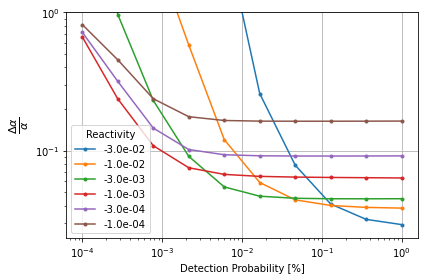

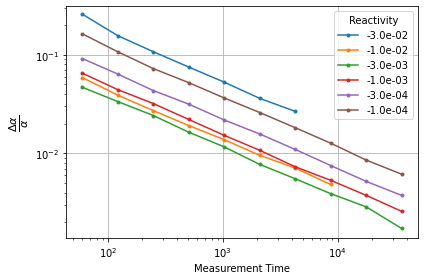

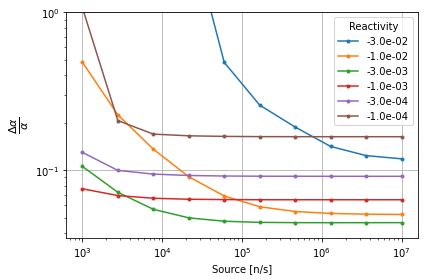

In [49]:
for key in defaults.keys():
    plt.figure()
    ymax, ymin = 0, 1
    for reactivity, data in datadict.items():
        subdata = data[:][condition(data, key, defaults.keys())]
        x = subdata[key].values
        if 'Detection' in key:
            x = 100 * x
        y = (subdata['Alpha STD'] / subdata['Alpha']).values
        plt.loglog(x, y, '.-', label=f'{reactivity:.1e}')
        ymax = max(ymax, max(y))
        ymin = min(ymin, min(y))
    plt.grid()
    plt.legend(title='Reactivity')
    plt.xlabel(f"{key.replace('Rate', 'Probability [%]').replace('Source', 'Source [n/s]')}")
    plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=16)
    plt.ylim([0.8*ymin, min(1.2*ymax, 1.)])
    plt.tight_layout()
    plt.savefig(f'SDE_Relative_Error_{key.replace(" ","_")}_per_Reactivity.jpg', dpi=600)

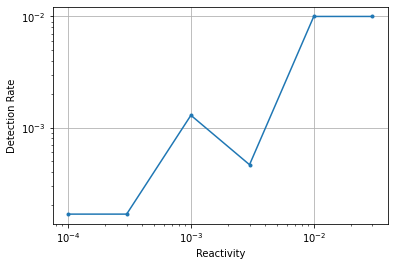

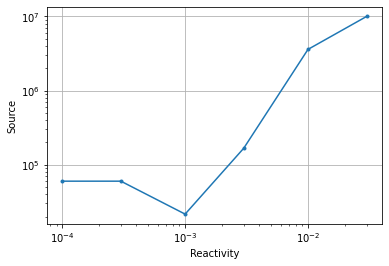

In [50]:
for key in ('Detection Rate', 'Source'):
    keydata = {r: asymptote(*map(lambda x: x.values, 
                                 xypair(data, key, defaults.keys())),
                           threshold=0.9e-2)
               for r, data in datadict.items()}
    rs, asyms = zip(*keydata.items())
    plt.figure()
    plt.loglog(np.abs(rs), asyms, '.-')
    plt.ylabel(key)
    plt.xlabel('Reactivity')
    plt.grid()

## Product Analysis

In [51]:
productdf = pd.read_csv('sde_std_product.csv').drop(columns=['Lifetime', 'Measurement Time'])
productdf

,Index,Reactivity,Source,Detection Probability,Seed,YInf,Alpha,YInfCov,YACov,AYCov,AlphaCov
0,1,-0.000500,1000.0,0.000001,600.0,5.10841,33.00290,2.81314,-23.999100,-23.999100,215.971000
1,1,-0.000500,1000.0,0.000001,600.0,32.59720,2.55260,3642.03000,-295.438000,-295.438000,23.974700
2,1,-0.000500,1000.0,0.000001,600.0,30.01510,3.00996,2366.93000,-247.373000,-247.373000,25.867000
3,1,-0.000500,1000.0,0.000001,600.0,34.43060,2.48211,5404.30000,-403.216000,-403.216000,30.094700
4,1,-0.000500,1000.0,0.000001,600.0,31.07860,2.82256,1991.58000,-188.040000,-188.040000,17.762600
...,...,...,...,...,...,...,...,...,...,...,...
735856,999,-0.001623,78476.0,0.006158,600.0,6355.57000,31.83060,58.92950,-0.395685,-0.395685,0.002849
735857,999,-0.001623,78476.0,0.006158,600.0,6319.17000,31.71310,638.38100,-4.293480,-4.293480,0.030956
735858,999,-0.001623,78476.0,0.006158,600.0,5995.47000,32.89170,47.78210,-0.352698,-0.352698,0.002801
735859,999,-0.001623,78476.0,0.006158,600.0,6054.96000,32.91230,86.59980,-0.633383,-0.633383,0.004985


In [52]:
keys = ['Reactivity', 'Source', 'Detection Probability']
grpd = productdf.groupby(keys)
stddata = grpd.std()['Alpha']
stddata.name = 'Alpha STD'
meandata = grpd.mean()['Alpha']
newdata = pd.concat([meandata, stddata], axis=1).reset_index()
reactivities = newdata.Reactivity.unique()
datadict = {reactivity: newdata[:][newdata.Reactivity == reactivity] for reactivity in reactivities}

In [53]:
def min_detection(data, source, cutoff):
    wdata = data[data.Source == source]
    probs = wdata['Detection Probability'].values
    y = (wdata['Alpha STD']/wdata['Alpha']).values
    mask = y<(1. + cutoff)*y.min()
    return probs[mask].min()


def min_source(data, detect, cutoff):
    wdata = data[data['Detection Probability'] == detect]
    probs = wdata['Source'].values
    y = (wdata['Alpha STD']/wdata['Alpha']).values
    mask = y<(1. + cutoff)*y.min()
    return probs[mask].min()


def pareto(single_reac_data, cutoff):
    sources = single_reac_data.Source.unique()
    detections = np.array([min_detection(single_reac_data, sv, cutoff) for sv in sources])
    return sources, detections


def otherway(single_reac_data, cutoff):
    detections = single_reac_data['Detection Probability'].unique()
    sources = np.array([min_source(single_reac_data, pd, cutoff) for pd in detections])
    return sources, detections
        

def plot_data(datadict, reactivity, cutoff, strategy=pareto):
    return *strategy(datadict[reactivity], cutoff), reactivity


def monotonic(x, op=operator.le):
    for i in reversed(range(len(x))):
        if not np.all(op(x[i:],x[i])):
            if i >= len(x):
                raise ValueError('There is no subset that monotonically decreases')
            return i+1
    return 0


def unique_mask(x):
    return [True if np.all(x[:i] != x[i]) else False for i in range(len(x))]
    

In [54]:
reactivity = -0.0005
cutoff = 0.05
tpls = [plot_data(datadict, r, cutoff) for r in datadict.keys()]
otpls = [plot_data(datadict, r, cutoff, strategy=otherway) for r in datadict.keys()]

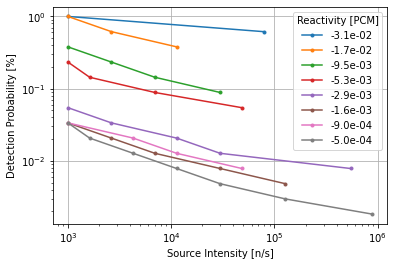

In [55]:
plt.figure()
for source, detect, label in tpls[2:]:
    dd = datadict[label]
    possib_errs = 100*dd['Alpha STD']/dd.Alpha
    minerr = possib_errs.min()
    mask = unique_mask(detect)
    source, detect = source[mask], detect[mask]
    pivot = monotonic(detect)
    mask = np.array([False if i<pivot else True for i in range(len(detect))])
    source, detect = source[mask], detect[mask]
    plt.loglog(source, 100*detect, '.-', label=f'{label:.1e}')
plt.grid()
plt.xlabel('Source Intensity [n/s]')
plt.ylabel('Detection Probability [%]')
plt.legend(title='Reactivity [PCM]', loc='upper right')
plt.show()

In [56]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

def linfit(x, b):
    return -2*x+b


1.8663047250248714 0.06109639508395463
LinregressResult(slope=-1.300001467802448, intercept=5.768572463878169, rvalue=-0.991240800273232, pvalue=0.000982786240747563, stderr=0.09999957435040312, intercept_stderr=0.561665039541516)
0.024237931803304226 0.009399418670658145
LinregressResult(slope=-1.79999974287063, intercept=1.1391753427555074, rvalue=-0.9938837786460356, pvalue=0.0005736669265670716, stderr=0.11546961842540787, intercept_stderr=0.6485552385602633)
-2.49648710616691 0.01409920571266935
LinregressResult(slope=-1.700000182145208, intercept=-0.8240841552530949, rvalue=-0.9948497700248882, pvalue=0.0004433411045985768, stderr=0.09999982621497948, intercept_stderr=0.5616664541828099)
-4.33855575048828 0.00939956245193719
LinregressResult(slope=-1.7999994012717289, intercept=-3.029713940296709, rvalue=-0.9938836735589354, pvalue=0.0005736817024317199, stderr=0.11547059765603816, intercept_stderr=0.7597964464818591)
-6.180622891191656 2.7554205756405267e-13
LinregressResult(slo

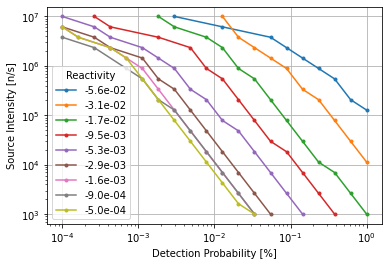

In [57]:
plt.figure()
for source, detect, label in otpls[1:]:
    dd = datadict[label]
    possib_errs = 100*dd['Alpha STD']/dd.Alpha
    minerr = possib_errs.min()
    pivot = monotonic(source)
    mask = np.array([False if i<pivot else True for i in range(len(source))])
    source, detect = source[mask], detect[mask]
    mask = unique_mask(source)
    source, detect = source[mask], detect[mask]
    plt.loglog(100*detect, source, '.-', label=f'{label:.1e}')
    reindex = np.argsort(detect)
    detect = detect[reindex][-5:]
    source = source[reindex][-5:]
    fy, fx = np.log(source), np.log(detect)
    pfit, pcov = curve_fit(linfit, fx, fy)
    regress = linregress(fx, fy)
    print(pfit[0], pcov[0,0])
    print(regress)
plt.grid()
plt.ylabel('Source Intensity [n/s]')
plt.xlabel('Detection Probability [%]')
plt.legend(title='Reactivity', loc='lower left')
plt.savefig('SDE Source to Detection Powerlaw.jpg', dpi=600)